In [26]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from pathlib import Path
import tensorflow as tf
import pandas as pd
from progressbar import ProgressBar
import warnings
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import tensorflow.keras as keras
warnings.filterwarnings('ignore')
progress = ProgressBar() 
def load_images_from_folder(folder):
    images = []
    for filename in progress(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (256, 256)) 
        if img is not None:
            images.append(img)
            
    img = np.array(images)
    del images
    return img

In [2]:
crop = load_images_from_folder('data\image\cropped')

100% (18448 of 18448) |##################| Elapsed Time: 0:01:10 Time:  0:01:10


In [3]:
df_clean = pd.read_csv("Covid_EDA_cropped.csv")
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18448 entries, 0 to 18447
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   File_no       18448 non-null  int64 
 1   Source        18448 non-null  object
 2   Catogery      18448 non-null  object
 3   Processed     18448 non-null  object
 4   Probe_Type    18448 non-null  object
 5   Frame_number  18448 non-null  object
dtypes: int64(1), object(5)
memory usage: 864.9+ KB


,File_no,Source,Catogery,Processed,Probe_Type,Frame_number
0,100,litfl,other,prc,convex,frame0
1,100,litfl,other,prc,convex,frame1
2,100,litfl,other,prc,convex,frame10
3,100,litfl,other,prc,convex,frame11
4,100,litfl,other,prc,convex,frame12


In [4]:
labs = []
for i in df_clean['Catogery']:
    if i == 'covid':
        labs.append(0)
    if i == 'normal':
        labs.append(1)
        
    if i =='other':
        labs.append(2)
    if i =='pneumonia':
        labs.append(3)

In [5]:
crop = crop.astype('float32') / 255
labs = np.array(labs)
labs = label_binarize(labs, classes=[0, 1, 2, 3])
n_classes = labs.shape[1]


In [6]:

from sklearn.model_selection import train_test_split


image_train, image_test, label_train, label_test = train_test_split(crop,labs,random_state=1, stratify=labs)

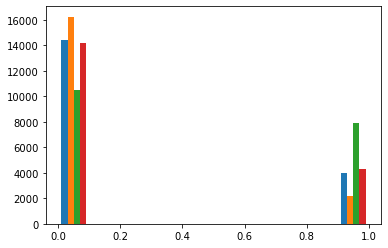

In [7]:
plt.hist(labs)
plt.show()

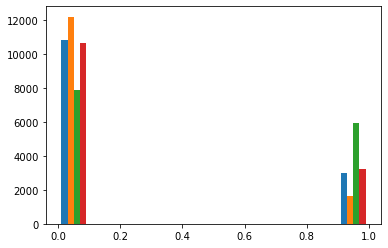

In [8]:
plt.hist(label_train)
plt.show()

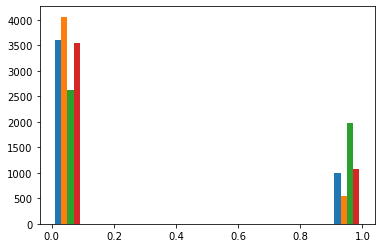

In [9]:
plt.hist(label_test)
plt.show()

In [10]:
print(image_train.shape)
print(len(label_train))
del crop
#image_train=image_train.reshape(840,1,256*256,3)

(13836, 256, 256, 3)
13836


In [11]:
print(image_test.shape)

(4612, 256, 256, 3)


In [12]:
image_test=image_test.reshape(4612,1*256*256*3)

In [13]:
print(image_test.shape)

(4612, 196608)


In [14]:
image_train=image_train.reshape(13836,1*256*256*3)

## Random Forest

In [20]:
classifier = OneVsRestClassifier(
    RandomForestClassifier(random_state=0)    
)
y_score = classifier.fit(image_train, label_train).predict(image_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

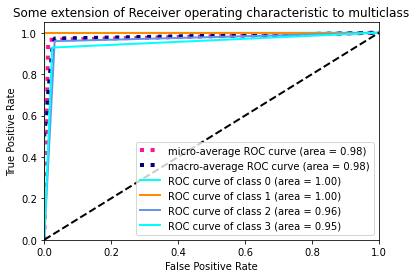

In [22]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## KNN

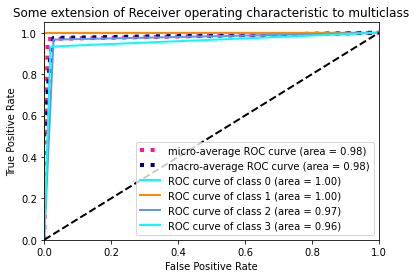

In [28]:
from sklearn.neighbors import KNeighborsClassifier
classifier = OneVsRestClassifier(
    KNeighborsClassifier(n_neighbors=5)    
)
y_score = classifier.fit(image_train, label_train).predict(image_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Naive Bayes

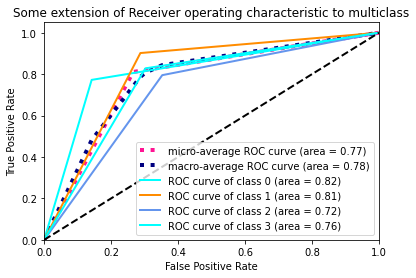

In [29]:
from sklearn.naive_bayes import GaussianNB

classifier = OneVsRestClassifier(
    GaussianNB()   
)
y_score = classifier.fit(image_train, label_train).predict(image_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()